# Final project: Dask execution

At this time you are going to adapt your preprocessing code (of the first part) to be distributed via DASK.

We will instantiate 2 different kind of DASK clusters:
- a local one, distributing task on the 2 threads of this jupyterlab instance
- a multi node one, consisting of 6 single thread worker nodes

We will then compare the performances, and, hopefully, observing some improvements

## Multi node cluster

## Initiate a local Dask scheduler on this machine

In [1]:
from distributed import Client
c_local = Client()
c_local

/opt/conda/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32951 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:32951/status,
Dashboard: http://127.0.0.1:32951/status,Workers: 3
Total threads: 3,Total memory: 4.39 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38149,Workers: 3
Dashboard: http://127.0.0.1:32951/status,Total threads: 3
Started: Just now,Total memory: 4.39 GiB
Comm: tcp://127.0.0.1:43055,Total threads: 1
Dashboard: http://127.0.0.1:37861/status,Memory: 1.46 GiB
Nanny: tcp://127.0.0.1:38871,


## Initiate a distributed scheduler with 6 workers

In [4]:
from dask_kubernetes.operator import KubeCluster

username = "dciangot"

cluster = KubeCluster(
    name=f'{username}',
    namespace=f'user-{username}', 
    image='dodasts/sosc22:v1',
    n_workers=4,
    worker_command=[
        'dask-worker',
        '--name=$(DASK_WORKER_NAME)',
        '--local-directory=temp_dir', 
        '--nthreads', '1',
        '--death-timeout', '60',
        '--memory-limit','2G'
    ],
    resources={
        "requests": {
            "memory": "2Gi",
            "cpu": "1"
        },
        "limits": {
            "memory": "3Gi",
            "cpu": "1"
        }
    }
)

In [5]:
c_distributed = Client(cluster)
c_distributed

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1361: VersionMismatchWarning: Mismatched versions found

+-------------+----------------+----------------+----------------+
| Package     | Client         | Scheduler      | Workers        |
+-------------+----------------+----------------+----------------+
| dask        | 2022.11.0      | 2022.10.0      | 2022.10.0      |
| distributed | 2022.11.0      | 2022.10.0      | 2022.10.0      |
| lz4         | 4.0.2          | 4.0.0          | 4.0.0          |
| numpy       | 1.23.5         | 1.23.4         | 1.23.4         |
| pandas      | 1.5.2          | 1.5.1          | 1.5.1          |
| python      | 3.10.8.final.0 | 3.10.6.final.0 | 3.10.6.final.0 |
+-------------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


<Client: 'tcp://10.42.64.163:8786' processes=1 threads=1, memory=1.86 GiB>

You can now visit the dashboard of your distributed resources here: `http://${YOUR JHUB USERNAME}-dask.131.154.96.42.myip.cloud.infn.it/status`

In [6]:
cluster.scale(4)

In [7]:
# Hint: upload a file (for instance a compiled C lib, cough cough... ) to your cluster via

#libpath = f"lib.{random.randint(0,0x7FFFF)}.so"
#run_shell(['gcc', '--shared', '-fPIC', '-o', "/tmp/" + libpath, 'src.C'])
#c_distributed.upload_file("/tmp/" + libpath)


alpha = 0.5

from subprocess import run as run_shell
import ctypes
import random
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import dask.array as da
from dask.distributed import Client
from dask.distributed import get_client
import dask.bag as db
import os
import glob


## Ex 1.a:  Distribute butt_filtfilt function on local dask

In [9]:
def butt_filtfilt(data):
    b, a = butter(4, 0.5/24)
    filtered = filtfilt(b, a, np.asarray(data))
    hf = data - filtered
    #hf = (hf - hf.mean(axis=1, keepdims=True))/hf.std(axis=1, keepdims=True)
    #hf = (hf - hf.mean(axis=0, keepdims=True))/hf.std(axis=0, keepdims=True)
    return hf

def create_hf(hf):
    hf = np.asarray(hf)
    hf = (hf - hf.mean(axis=1, keepdims=True))/hf.std(axis=1, keepdims=True)
    hf = (hf - hf.mean(axis=0, keepdims=True))/hf.std(axis=0, keepdims=True)
    return hf

df =  pd.read_csv("https://pandora.infn.it/public/806aa1/dl/exoTrain.csv")
data = df[df.columns[1:]].values[:]
label = df.LABEL.values

In [11]:
%%time
import dask
from distributed.client import temp_default_client
with temp_default_client(c_local):
    b = db.from_sequence(data, npartitions=10)
    b = b.map(butt_filtfilt)

    hf = b.compute()
    hf = np.asarray(hf)
    hf = (hf - hf.mean(axis=1, keepdims=True))/hf.std(axis=1, keepdims=True)
    preprocessed_array_local = (hf - hf.mean(axis=0, keepdims=True))/hf.std(axis=0, keepdims=True)

CPU times: user 1.93 s, sys: 450 ms, total: 2.38 s
Wall time: 3.74 s


## Ex 1.b: distribute the same function on the remote cluster

In [12]:
%%time

with temp_default_client(c_distributed):
    b = db.from_sequence(data, npartitions=30)
    b = b.map(butt_filtfilt)

    hf = b.compute()
    hf = np.asarray(hf)
    hf = (hf - hf.mean(axis=1, keepdims=True))/hf.std(axis=1, keepdims=True)
    preprocessed_array_dist = (hf - hf.mean(axis=0, keepdims=True))/hf.std(axis=0, keepdims=True)

CPU times: user 1.67 s, sys: 315 ms, total: 1.99 s
Wall time: 4.45 s


## Ex 2: finalize the preparation of the array to be ready for get_period function 

In [13]:
preprocessed_array_dist

array([[-0.00560481,  0.00815121, -0.39302846, ...,  0.89725981,
         0.60808357,  0.27181991],
       [-0.57161809, -0.0388296 , -0.4481701 , ...,  0.28704731,
         0.47241217,  0.51792041],
       [-0.31544384, -0.03217147, -0.12819833, ...,  0.16141996,
        -0.06033178, -0.21516395],
       ...,
       [ 0.82562673,  0.39773086,  0.19783493, ...,  1.11096206,
         1.11263351,  1.08749455],
       [ 0.05170403, -0.10287707, -0.52744597, ..., -0.74406224,
        -0.19624241,  0.11060709],
       [ 1.7256563 ,  0.33692418,  0.25951201, ..., -0.53657652,
        -0.58812676,  0.0453725 ]])

## Ex 3.a: distribute and measure the duration of the of compute_period function on the local dask
- also check the period distribution plot 

In [14]:

print("""
    #include <math.h>

    extern "C"
    int best_matching_period (int n, double alpha, double* lumi) {
        int i, j, k, best_period;
        double score, min_score = 9999.;
        
        for (i = 100; i < n/2; ++i)
            for (j = 1; j < i; ++j) {
                score = 0;
                for (k = j; k < n; k+= i) score += lumi[k];
                score /= pow(n/i, alpha);
                
                if (score < min_score) {
                    min_score = score;
                    best_period = i;
                }
            }
        return best_period;
    }
    """, file=open('src.C', 'w'))
    
libpath = f"lib.{random.randint(0,0x7FFFF)}.so"
run_shell(['gcc', '--shared', '-fPIC', '-o', "/tmp/" + libpath, 'src.C'])
c_distributed.upload_file("/tmp/" + libpath)

def compute_period(data, dask_distributed=False):
    
    if dask_distributed:
        path = glob.glob("/home/jovyan/temp_dir/dask-worker-space/worker-*/" + libpath)[0]
    else:
        path = "/tmp/" + libpath
    lib = ctypes.cdll.LoadLibrary(path)
    lib.best_matching_period.restype = ctypes.c_int
    lib.best_matching_period.argtypes = [
        ctypes.c_int, 
        ctypes.c_double, 
        np.ctypeslib.ndpointer(dtype=np.float64)
    ]
    

    return lib.best_matching_period(len(data), alpha, data);

def map_fn(fn, x):
    ...

    # Get locally created client
    client = get_client()

    # Do normal client operations, asking cluster for computation
    futures = client.map(fn, (x))
    array = client.gather(futures)

    return array

from functools import partial


In [15]:
%%time
with temp_default_client(c_local):
    preprocessed_array_scattered = c_local.scatter(preprocessed_array_local)
    get_periods = dask.delayed(map_fn)(partial(compute_period, dask_distributed=False), preprocessed_array_scattered)

    periods = np.array(get_periods.compute())


CPU times: user 8.51 s, sys: 1.01 s, total: 9.52 s
Wall time: 1min 55s


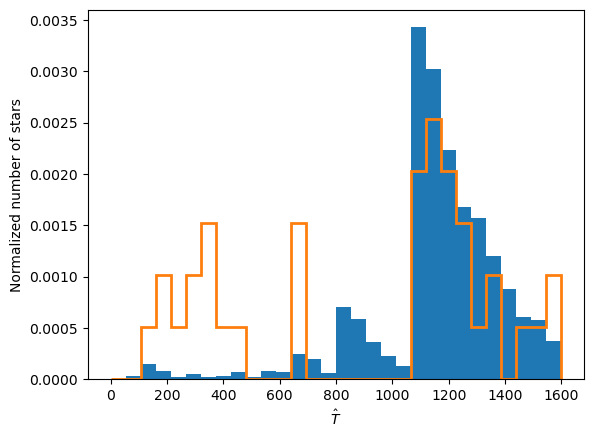

In [16]:
bins = np.linspace(0, 1600, 31)
plt.hist(periods, bins=bins, density=True)
plt.hist(periods[label == 2], bins=bins, density=True, histtype='step', linewidth=2)
plt.xlabel("$\hat T$")
plt.ylabel("Normalized number of stars")
plt.show()

## Ex 3.b: distribute and measure the duration of the of compute_period function on the remote cluster
- also check the period distribution plot 

In [17]:
%%time

with temp_default_client(c_distributed):
    preprocessed_array_scattered = c_distributed.scatter(preprocessed_array_dist)
    get_periods = dask.delayed(map_fn)(partial(compute_period, dask_distributed=True), preprocessed_array_scattered)

    periods = np.array(get_periods.compute())

CPU times: user 1.86 s, sys: 170 ms, total: 2.03 s
Wall time: 44.3 s


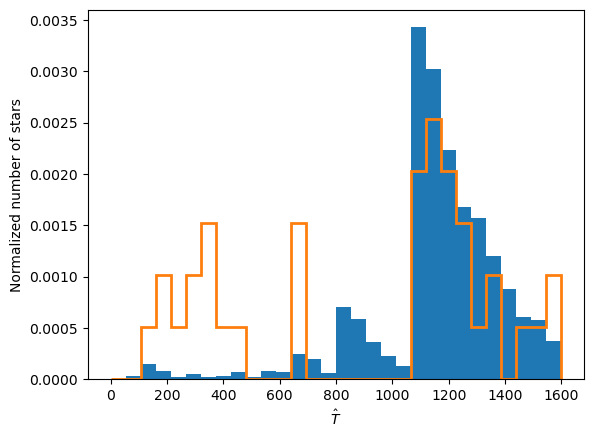

In [18]:
bins = np.linspace(0, 1600, 31)
plt.hist(periods, bins=bins, density=True)
plt.hist(periods[label == 2], bins=bins, density=True, histtype='step', linewidth=2)
plt.xlabel("$\hat T$")
plt.ylabel("Normalized number of stars")
plt.show()

## Ex 4. (BONUS): Execute the steps of ex 1 and 2 (with local dask) on an argo workflow

- Running the get_period task after the first preprocessing is done.
- Store the period plot on minio

### Create the image with the first step

- put the related code into a `step1.py`
- create a docker file in the form of:

```
FROM dodasts/sosc22:v1

COPY ./step1.py /opt/step1.py
```

- `docker build . -t dciangot/mycode:v1`
- `docker push dciangot/mycode:v1`

### Create the image with the compute period

- put the related code into a `compute_period.py`
- create a docker file in the form of:

```
FROM dodasts/sosc22:v1

COPY ./compute_period.py /opt/compute_period.py
```

- `docker build . -t dciangot/mycode-compute-period:v1`
- `docker push dciangot/mycode-compute-period:v1`

### Use the image to define your task

In [ ]:
from hera import ImagePullPolicy, Task, Workflow
import uuid

with Workflow(f"part3-automation-{uuid.uuid4()}", service=svc) as w:
    # This can be used when you have your own custom image
    # Image_pull_policy is set to Never because on localhost when you test
    # you don't need to pull the image
    w_t = Task(
        "workflow-with-custom-image",
        image="dciangot/mycode:v1",
        image_pull_policy=ImagePullPolicy.Never,
        command=["python", "-m", "/opt/step1.py"],
        outputs=[Artifact("test", "/opt/preprocessed_array.pkl")]
    )
    c_t = Task(
        "compute_period",
        image="dciangot/mycode-compute-period:v1",
        image_pull_policy=ImagePullPolicy.Never,
        command=["python", "-m", "/opt/compute_period.py"],
        inputs=[w_t.get_artifact("test")],
        outputs=[Artifact("plot", "/opt/plot.png")]
    )

    w_t >> c_t

w.create()